In [74]:
import pandas as pd
import numpy as np
## For plotting
import matplotlib.pyplot as plt
import xarray as xr

ds = xr.open_mfdataset("/Users/james/Documents/Github/geog473-673/datasets/WCr*")['air_temperature']
ds_daily = ds.resample(time='1D').mean()
temp_daily = pd.DataFrame(index=pd.to_datetime(ds_daily.time.values),data=ds_daily.isel(latitude=0, longitude=0).values, columns=['airT'])

train = temp_daily['2010-01-01':'2012-05-31']
test = temp_daily['2012-06-01':'2012-12-31']

In [143]:
#Feature Scaling 
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0,1))

training_set_scaled = sc.fit_transform(temp_daily)

In [167]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps, n_future):
    X, Y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        Y.append(seq_y)
    return array(X), array(Y)

In [215]:
# split a univariate sequence into samples
def split_sequence(sequence, n_input, n_output):
    X, Y = list(), list()
    for i in range(len(sequence)-n_input-n_output+1):
        # find the end of this pattern
        end_ix = i + n_input
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix, 0], sequence[end_ix: end_ix + n_output, 0]
        X.append(seq_x)
        Y.append(seq_y)
    return array(X), array(Y)

In [219]:
x_train = []
y_train = []
n_future = 4 # next 4 days temperature forecast
n_past = 30 # Past 30 days 
for i in range(0,len(training_set_scaled)-n_past-n_future+1):
    x_train.append(training_set_scaled[i : i + n_past , 0])     
    y_train.append(training_set_scaled[i + n_past : i + n_past + n_future , 0 ])
x_train , y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0] , x_train.shape[1], 1) )

In [220]:
x_train.shape

(1064, 30, 1)

In [217]:
x_train , y_train = split_sequence(training_set_scaled, n_past, n_future)
x_train.shape

(1064, 30)

In [199]:
y_train.reshape(1)

ValueError: cannot reshape array of size 4256 into shape (1,)

In [145]:
from keras.models import Sequential
from keras.layers import LSTM,Dense ,Dropout
# Fitting RNN to training set using Keras Callbacks. Read Keras callbacks docs for more info.

In [161]:
regressor = Sequential()
regressor.add(Bidirectional(LSTM(units=30, return_sequences=True, input_shape = (x_train.shape[1],1) ) ))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units= 30 , return_sequences=True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units= 30 , return_sequences=True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units= 30))
regressor.add(Dropout(0.2))
regressor.add(Dense(units = n_future,activation='linear'))
regressor.compile(optimizer='adam', loss='mean_squared_error',metrics=['acc'])
regressor.fit(x_train, y_train, epochs=200,batch_size=32, verbose=0 )


KeyboardInterrupt: 

In [158]:
train = temp_daily['2010-01-01':'2012-05-31']
test = temp_daily['2012-06-01':'2012-12-31']
testdataset = train
real_temperature = train
testing = sc.transform(testdataset)
testing = np.array(testing)
testing = np.reshape(testing,(testing.shape[1],testing.shape[0],1))

In [159]:
predicted_temperature = regressor.predict(testing)
predicted_temperature = sc.inverse_transform(predicted_temperature)
predicted_temperature = np.reshape(predicted_temperature,(predicted_temperature.shape[1],predicted_temperature.shape[0]))

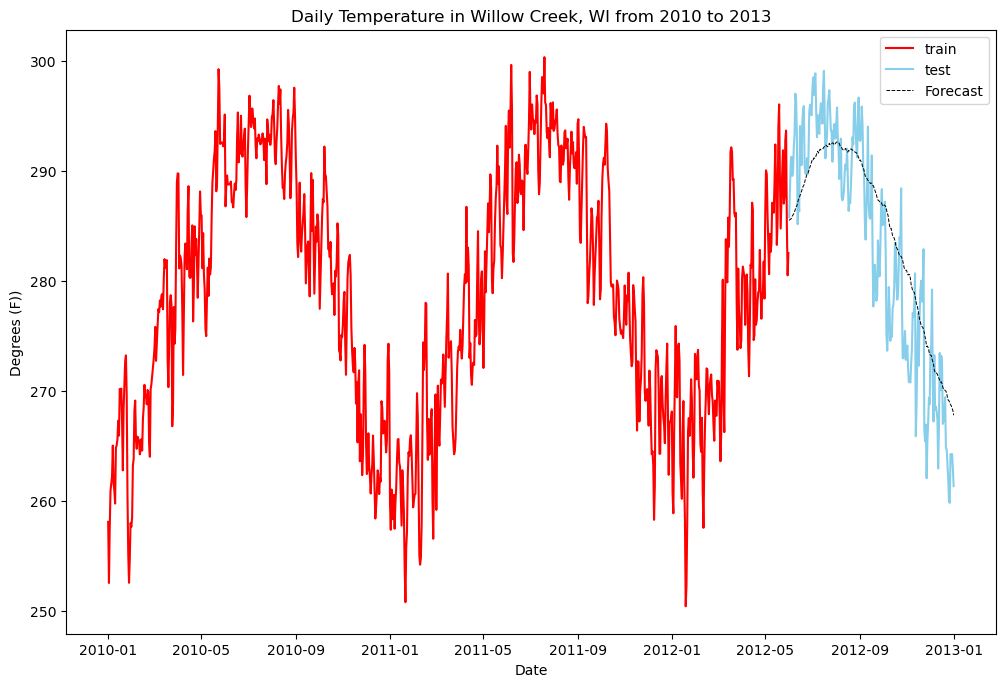

In [160]:
# Plot the daily temperature change via pandas
fig, ax = plt.subplots(figsize=(12,8), dpi=100)
plt.plot(train.index, train.airT, color='red', label='train')
plt.plot(test.index, test.airT, color='skyblue', label='test')
plt.plot(test.index, predicted_temperature, color='k',label='Forecast', linestyle='dashed', linewidth='0.7')

plt.gca().set(title="Daily Temperature in Willow Creek, WI from 2010 to 2013", xlabel='Date', ylabel="Degrees (F))")
ax.legend()
plt.show()